# v2e Tutorial

This colab script is to demonstrate the use of v2e.

For more technical details, please find in our paper:
**v2e: From Video Frames to Realistic DVS Events** (https://arxiv.org/abs/2006.07722)

Our YouTube Tutorial: https://www.youtube.com/watch?v=THJqRC_q2kY&t

Colab provides free GPU resources, you can also use this script as a tool for converting videos to events.

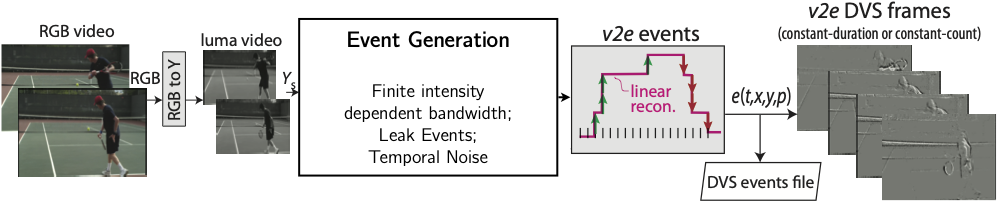

## Check Colab Runtime

**Make sure you are using GPU runtime. Otherwise, go to Runtime->Change runtime type to change.**

In [ ]:
!nvidia-smi  # check if the GPU is working properly
%rm -rf ./sample_data  # remove the sample data

## Setup v2e

In [ ]:
# Installing dependencies
%pip install numba
%pip install engineering-notation
%pip install opencv-contrib-python
%pip install argcomplete

# other dependencies that's already preinstalled in the environment
# you need to install these additional dependencies in your local environment

# pip install torch torchvision -U  # Follow the instructions here: https://pytorch.org/get-started/locally/
# pip install numpy
# pip install matplotlib
# pip install h5py
# pip install tqdm

In [ ]:
# Clone and install
!git clone https://github.com/SensorsINI/v2e
%cd /content/v2e
#!python setup.py develop
%pip install .
!mkdir input
%cd /content/
%pwd

In [ ]:
# download super-slomo checkpoint
# actual checkpoint is here: https://drive.google.com/file/d/17QSN207h05S_b2ndXjLrqPbBTnYIl0Vb/view?usp=sharing
# in local environment, download and put it in the folder /path/to/v2e/input

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17QSN207h05S_b2ndXjLrqPbBTnYIl0Vb' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17QSN207h05S_b2ndXjLrqPbBTnYIl0Vb" -O /content/v2e/input/SuperSloMo39.ckpt && rm -rf /tmp/cookies.txt

## Upload a Video

### For the purpose of this tutorial, let's use a sample video

You can later remove this section for your own use

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kHW820MQ9SoYX8HVeMJO0uugnxp2JptO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kHW820MQ9SoYX8HVeMJO0uugnxp2JptO" -O v2e_tutorial_video.avi && rm -rf /tmp/cookies.txt

---
### For your own video, upload it here

Click file explorer on the left, there are three buttons on the top: Upload, Refresh and Mount Drive.

Click the upload button and upload.

You can upload a video file or a zip file that contains a folder of images.


---



### If you have data on your Google Drive (Recommend)

Click file explorer on the left, there are three buttons on the top: Upload, Refresh and Mount Drive.

Click "Mount Drive", Colab will ask for your permission to mount.
Once you agreed, the drive will be mounted at `/content/drive`


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Select the Video

In [ ]:
#@title In the file explorer, right click the video file, and then click "Copy Path". Then, paste the path here: { run: "auto", vertical-output: true }
video_path = "/content/v2e_tutorial_video.avi" #@param {type:"string"}

import os
if video_path != "" and os.path.isfile(video_path):
    display("The chosen video file: {}".format(video_path))
else:
    print("The file path is empty or invalid, choose a file")


In [ ]:
# play the sample video, you can ignore it, support both AVI and MP4
# you can ignore this if you don't need
if ".avi" in video_path:
    !ffmpeg -y -i $video_path /tmp/output.mp4 -loglevel quiet
else:
    !cp $video_path /tmp/output.mp4

from IPython.display import HTML
from base64 import b64encode
mp4 = open("/tmp/output.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("<video controls src={} width=50%/>".format(data_url))

In [ ]:
# If the video is a zip file, decompress it and remove the file
# otherwise, you can ignore this

if ".zip" in video_path:
    # decompress the file
    !unzip $video_path
    %rm $video_path

# select the video path again here
#@title In the file explorer, right click the video file, and then click "Copy Path". Then, paste the path here: { run: "auto", vertical-output: true }
video_path = "" #@param {type:"string"}

## Convert the Video to Events!

In [ ]:
#@title **Configure V2E Options** { run: "auto", vertical-output: true, display-mode: "both" }
#@markdown The full documentation is here: https://github.com/SensorsINI/v2e#render-emulated-dvs-events-from-conventional-video

#@markdown This GUI supports only common use configs, for finer control, please check the v2e documentation and edit the code below.

#@markdown ---
#@markdown ## Output Options

output_folder = "/content/v2e-output" #@param {type:"string"}
#@markdown - folder to store outputs. (default: v2e-output)
overwrite = True #@param {type:"boolean"}
#@markdown - overwrites files in existing folder (checks existence of non-empty output_folder). (default: True)
unique_output_folder = False #@param {type:"boolean"}
#@markdown - makes unique output folder based on output_folder, e.g. output1 (if non-empty output_folder already exists) (default: False)
out_filename = "events.h5" #@param {type:"string"}
#@markdown - Output DVS events as hdf5 event database.
davis_output = True #@param {type:"boolean"}
#@markdown - If also save frames in HDF5. (default: False)

#@markdown ### Output DVS Video Options
skip_video_output = False #@param {type:"boolean"}
#@markdown - Skip producing video outputs, including the original video, SloMo video, and DVS video (default: False)
dvs_exposure = "duration .033" #@param {type:"string"}
#@markdown - Mode to finish DVS frame event integration: duration time: Use fixed accumulation time in seconds, e.g. --dvs_exposure duration .005; count n: Count n events per frame, -dvs_exposure count 5000; area_event N M: frame ends when any area of M x M pixels fills with N events, -dvs_exposure area_count 500 64 (default: duration 0.01)

#@markdown ---

#@markdown ## Input Options
input_frame_rate = 30 #@param {type:"number"}
#@markdown - Manually define the video frame rate when the video is presented as a list of image files. When the input video is a video file, this option will be ignored.
input_slowmotion_factor =  1#@param {type:"number"}
#@markdown - Sets the known slow-motion factor of the input video, i.e. how much the video is slowed down, i.e., the ratio of shooting frame rate to playback frame rate. input_slowmotion_factor<1 for sped-up video and input_slowmotion_factor>1 for slowmotion video.If an input video is shot at 120fps yet is presented as a 30fps video (has specified playback frame rate of 30Hz, according to file's FPS setting), then set --input_slowdown_factor=4.It means that each input frame represents (1/30)/4 s=(1/120)s.If input is video with intended frame intervals of 1ms that is in AVI file with default 30 FPS playback spec, then use ((1/30)s)*(1000Hz)=33.33333. (default: 1.0)

#@markdown ---

#@markdown ## DVS Time Resolution Options
disable_slomo = True #@param {type:"boolean"}
#@markdown - Disables slomo interpolation; the output DVS events will have exactly the timestamp resolution of the source video (which is perhaps modified by --input_slowmotion_factor). (default: False)
timestamp_resolution = 0.001 #@param {type:"number"}
#@markdown - (Ignored by --disable_slomo.) Desired DVS timestamp resolution in seconds; determines slow motion upsampling factor; the video will be upsampled from source fps to achieve the at least this timestamp resolution.I.e. slowdown_factor = (1/fps)/timestamp_resolution; using a high resolution e.g. of 1ms will result in slow rendering since it will force high upsampling ratio. Can be combind with --auto_timestamp_resolution to limit upsampling to a maximum limit value. (default: None)
auto_timestamp_resolution = True #@param {type:"boolean"}
#@markdown - (Ignored by --disable_slomo.) If True (default), upsampling_factor is automatically determined to limit maximum movement between frames to 1 pixel. If False, --timestamp_resolution sets the upsampling factor for input video. Can be combined with --timestamp_resolution to ensure DVS events have at most some resolution. (default: False)

# This is the SloMo model path
slomo_model = "/content/v2e/input/SuperSloMo39.ckpt"

#@markdown ---

#@markdown ## DVS Model Options
condition = "Noisy" #@param ["Custom", "Clean", "Noisy"]
#@markdown - Custom: Use following slidebar to adjust your DVS model.
#@markdown - Clean: a preset DVS model, generate clean events, without non-idealities.
#@markdown - Noisy: a preset DVS model, generate noisy events.

thres = 0.2 #@param {type:"slider", min:0.05, max:1, step:0.01}
#@markdown - threshold in log_e intensity change to trigger a positive/negative event. (default: 0.2) 
sigma = 0.03 #@param {type:"slider", min:0.01, max:0.25, step:0.001}
#@markdown - 1-std deviation threshold variation in log_e intensity change. (default: 0.03)
cutoff_hz = 200 #@param {type:"slider", min:0, max:300, step:1}
#@markdown - photoreceptor first-order IIR lowpass filter cutoff-off 3dB frequency in Hz - see https://ieeexplore.ieee.org/document/4444573 (default: 300)
leak_rate_hz = 5.18 #@param {type:"slider", min:0, max:100, step:0.01}
#@markdown - leak event rate per pixel in Hz - see https://ieeexplore.ieee.org/abstract/document/7962235 (default: 0.01)
shot_noise_rate_hz = 2.716 #@param {type:"slider", min:0, max:100, step:0.001}
#@markdown - Temporal noise rate of ON+OFF events in darkest parts of scene; reduced in brightest parts. (default: 0.001)

if condition == "Clean":
    thres = 0.2
    sigma = 0.02
    cutoff_hz = 0
    leak_rate_hz = 0
    shot_noise_rate_hz = 0
elif condition == "Noisy":
    thres = 0.2
    sigma_thres = 0.05
    cutoff_hz = 30
    leak_rate_hz = 0.1
    shot_noise_rate_hz = 5

#@markdown ---

v2e_command = ["v2e"]

# set the input folder
# the video_path can be a video file or a folder of images
v2e_command += ["-i", video_path]

# set the output folder
v2e_command += ["-o", output_folder]

# if the output will rewrite the previous output
if overwrite:
    v2e_command.append("--overwrite")

# if there the output folder is unique
v2e_command += ["--unique_output_folder", "{}".format(unique_output_folder).lower()]

# set output configs, for the sake of this tutorial, let's just output HDF5 record
if davis_output:
    v2e_command += ["--davis_output"]
v2e_command += ["--dvs_h5", out_filename]
v2e_command += ["--dvs_aedat2", "None"]
v2e_command += ["--dvs_text", "None"]

# in Colab, let's say no preview
v2e_command += ["--no_preview"]

# if skip video output
if skip_video_output:
    v2e_command += ["--skip_video_output"]
else:
    # set DVS video rendering params
    v2e_command += ["--dvs_exposure", dvs_exposure]

# set slomo related options
v2e_command += ["--input_frame_rate", "{}".format(input_frame_rate)]
v2e_command += ["--input_slowmotion_factor", "{}".format(input_slowmotion_factor)]

# set slomo data
if disable_slomo:
    v2e_command += ["--disable_slomo"]
    v2e_command += ["--auto_timestamp_resolution", "false"]
else:
    v2e_command += ["--slomo_model", slomo_model]
    if auto_timestamp_resolution:
        v2e_command += ["--auto_timestamp_resolution", "{}".format(auto_timestamp_resolution).lower()]
    else:
        v2e_command += ["--timestamp_resolution", "{}".format(timestamp_resolution)]

# threshold
v2e_command += ["--pos_thres", "{}".format(thres)]
v2e_command += ["--neg_thres", "{}".format(thres)]

# sigma
v2e_command += ["--sigma_thres", "{}".format(sigma)]

# DVS non-idealities
v2e_command += ["--cutoff_hz", "{}".format(cutoff_hz)]
v2e_command += ["--leak_rate_hz", "{}".format(leak_rate_hz)]
v2e_command += ["--shot_noise_rate_hz", "{}".format(shot_noise_rate_hz)]

# Final v2e command

final_v2e_command = " ".join(v2e_command)

print("The Final v2e command:")
display(final_v2e_command)


In [ ]:
# Run command!
!$final_v2e_command

## Quick Visualization and Output Summary

In [ ]:
# Output file path
import os
import h5py
out_filepath = os.path.join(output_folder, out_filename)
out_dataset = h5py.File(out_filepath, "r")

file_stats = os.stat(out_filepath)

# Summarize file

events = out_dataset["events"]

num_events = events.shape[0]
duration = (events[-1, 0]-events[0, 0])/1e6  # in seconds
event_rate = num_events/duration/1000

display("File Size (MB): {:.2f}".format(file_stats.st_size / (1024*1024)))
display("Number of Events: {}".format(events.shape[0]))
display("Recording Duration: {:.2f}s".format(duration))
display("Event Rate: {:.2f} KEVs/s".format(event_rate))

In [ ]:
# SloMo Video
slomo_vid_path = os.path.join(output_folder, "video_slomo.avi")
!ffmpeg -y -i $slomo_vid_path /tmp/output.mp4 -loglevel quiet

from IPython.display import HTML
from base64 import b64encode
mp4 = open("/tmp/output.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("<video controls src={} width=50%/>".format(data_url))

In [ ]:
# DVS Video
dvs_vid_path = os.path.join(output_folder, "dvs-video.avi")
!ffmpeg -y -i $dvs_vid_path /tmp/output.mp4 -loglevel quiet

from IPython.display import HTML
from base64 import b64encode
mp4 = open("/tmp/output.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("<video controls src={} width=50%/>".format(data_url))

## Download the Output File

Use the file explorer on the left to download the data.

Because Colab notebook itself support a slow download. I hence recommend that you can save your output in a Google Drive folder.

## Beyond Single File Conversion

This tutorial setup is for a single file conversion.
For multiple files, the ideal way is to use `v2e.py` script as subprocesses like we showed here.

For a simple demonstration, please checkout the following example for converting
the Caltech-101 dataset.

Link: https://gist.github.com/duguyue100/f60bdc1eb0e5b51586ca3594d9d72cb7

# Use v2e Event Emulator in 3rd-party program

You might want to use the EventEmulator in a third party application.

A typical scenario will be that a simulator output frames and the the emulator will convert the frames into events.

In this section, we provide an example of using the emulator to convert a video into events.

**Side Note**: The performance bottleneck of the emulator is at writing events into the disk. There are two ways to look at this problem:

1. When collecting training data, it's probably fine writing all the data into disk.

2. Use library such as `zeromq` to build a multi-process application so that one process runs the emulator and another application writes the events into the disk.

In [ ]:
# define a emulator
from v2ecore.emulator import EventEmulator

emulator = EventEmulator(
    pos_thres=0.2,
    neg_thres=0.2,
    sigma_thres=0.03,
    cutoff_hz=200,
    leak_rate_hz=1,
    shot_noise_rate_hz=10,
    device="cuda"
)

In [ ]:
import torch
# **IMPORTANT** make torch static, likely get faster emulation
# might also cause memory issue
torch.set_grad_enabled(False)
# read a video from opencv
import cv2

cap = cv2.VideoCapture(video_path)

# num of frames
fps = cap.get(cv2.CAP_PROP_FPS)
print("FPS: {}".format(fps))
num_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Num of frames: {}".format(num_of_frames))

duration = num_of_frames/fps
delta_t = 1/fps
current_time = 0.

print("Clip Duration: {}s".format(duration))
print("Delta Frame Tiem: {}s".format(delta_t))
print("="*50)

new_events = None

idx = 0
# Only Emulate the first 10 frame
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret is True and idx < 10:
        # convert it to Luma frame
        luma_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print("="*50)
        print("Current Frame {} Time {}s".format(idx, current_time))
        print("-"*50)

        # emulate events
        # **IMPORTANT** The unit of timestamp here is in second, a floating number
        new_events = emulator.generate_events(luma_frame, current_time)

        ### The output events is in a numpy array that has a data type of np.int32
        ### THe shape is (N, 4), each row is one event in the format of (t, x, y, p)
        ### The unit of timestamp here is in microseconds

        # update time
        current_time += delta_t

        # print event stats
        if new_events is not None:
            num_events = new_events.shape[0]
            start_t = new_events[0, 0]
            end_t = new_events[-1, 0]
            event_time = (new_events[-1, 0]-new_events[0, 0])
            event_rate_kevs = (num_events/delta_t)/1e3

            print("Number of Events: {}\n"
                  "Duration: {}s\n"
                  "Start T: {:.5f}s\n"
                  "End T: {:.5f}s\n"
                  "Event Rate: {:.2f}KEV/s".format(
                      num_events, event_time, start_t, end_t,
                      event_rate_kevs))
        idx += 1
        print("="*50)
    else:
        break

cap.release()

## Conversion for the first frame is slow

When emulator processes the first frame, the emulator also need to initialize itself by generating many variables and random numbers.
Therefore, it's much much slower to process the first frame.

I suggest that this can be dealt with as a separate case in your code when needed.

In [ ]:
# Reset a emulator
emulator.reset()

## What a ROS module could look like?

In [ ]:
# NOT RUNNABLE, just for demonstration

# define a emulator
from v2ecore.emulator import EventEmulator
import rospy

class EventGenerator:
    def __init__(self):
        self.emulator = EventEmulator(
            pos_thres=0.2,
            neg_thres=0.2,
            sigma_thres=0.03,
            cutoff_hz=200,
            leak_rate_hz=1,
            shot_noise_rate_hz=10,
            device="cuda")
        
        self.events = None
        
        # init a node
        rospy.init_node("event_generator", anonymous=True)

        # define a event publisher
        self.event_publisher = rospy.Publisher(
            '/dvs_events', events_message, queue_size=10)

        # subscribe to an RGB camera
        self.camera = rospy.Subscriber(
            '/rgb_topic', Image, self.callback, queue_size=10,
            buff_size=262144)
        
        rospy.Timer(rospy.Duration(0.01), self.send_events)

    def callback(self, camera_info):
        # fetch data
        self.image = get_image()
        self.t = get_time()

        # generate events
        self.events = self.emulator.generate_events(self.image, self.t)

    def send_events(self):
        if self.events is not None:
            # someone need to write this message
            msg = EventMSG()

            msg.events = self.events 
            self.event_publisher.publish(msg)

if __name__ == "__main__":
    event_generator = EventGenerator()
    rospy.spin()

## Final note, Color Events

1. A luma frame cannot represent all colors in a RGB frame.
2. If you want to get color events, one for each R, G, and B channels, use three emulators for different channels.
3. Your emulation speed might be slowed down at least 3X.